## Extracting TripAdvisor Reviews with Python

Analyzing the "voice-of-the-customer" is the foundation of the market research industry. Typically, the industry has relied on two main methodologies and slight derivatives: surveys and focus groups. While it is unlikely that both of these methodologies will fall completely out of use, there are alternative techniques that utilize the power of modern analytics to extract valuable consumer information.

The following is a brief exploration of using Python, Scrapy, the Natural Language Toolkit (NLTK), the **V**alence **A**ware **D**ictionary and s**E**ntiment **R**easoner (VADER) sentiment analyzer, and Scattertext, an NLP visualizer. The goal is to explore hotel and resort ratings for the Island of Hawai'i from TripAdvisor, understand consumer sentiment as it relates to different amenities, and visualize how reviews differ between positive and negative.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
import scattertext as st
import spacy 
from IPython.display import IFrame
from IPython.core.display import display, HTML
%matplotlib inline
display(HTML("<style>.container { width:98% !important; }</style>"))

First, we need to gather reviews. TripAdvisor (TA) is the number one travel site in the U.S. and boasts over 500 million hotel and resort reviews. For this demonstration, we are only interested in hotels/resorts on the Island of Hawai'i. Considering the island's heavy tourism industry, we have plenty of reviews to work with.

The script below uses the Python package Scrapy which is designed specifically for web scraping tasks. To summarize, we provide an initial starting URL for the scraper -- in this case the first page of results when we search for *"Island of Hawai'i"* on TA-- and then use XPath references to extract review text from the underlying HTML code. This script first follows the link to a hotel's review page, extracts all reviews on the first page and subsequent pages, then goes back to the starting URL and follows the link to the next hotet, extracts all reviews...and so on until all reviews for all hotels have been scraped and added to an output CSV document.

Referencing the function **"parse_review"** below, we've extracted the review headline, text, bubble rating, date, and hotel.

In [ ]:
import scrapy
from tripadvisor.items import TripadvisorItem

class TrSpider(scrapy.Spider):
    name = 'trspider'
    start_urls = [
            'https://www.tripadvisor.com/Hotels-g29217-Island_of_Hawaii_Hawaii-Hotels.html'
            ]

    def parse(self, response):
        for href in response.xpath('//div[@class="listing_title"]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_hotel)

        next_page = response.xpath('//div[@class="unified pagination standard_pagination"]/child::*[2][self::a]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse)

    def parse_hotel(self, response):
        for href in response.xpath('//div[starts-with(@class,"quote")]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_review)


        next_page = response.xpath('//link[@rel="next"]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse_hotel)

    def parse_review(self, response):
        item = TripadvisorItem()
        item['headline'] = response.xpath('translate(//div[@class="quote"]/text(),"!"," ")').extract()[0][1:-1]
        item['review'] = response.xpath('translate(//div[@class="entry"]/p,"\n"," ")').extract()[0]
        item['bubbles'] = response.xpath('//span[contains(@class,"ui_bubble_rating")]/@alt').extract()[0]
        item['date'] = response.xpath('normalize-space(//span[contains(@class,"ratingDate")]/@content)').extract()[0]
        item['hotel'] = response.xpath('normalize-space(//span[@class="altHeadInline"]/a/text())').extract()[0]
        return item

The raw output generates a file with **~41,500** records spanning the dates of **2003-01-20** to **2017-07-20** -- over 14 years of reviews! Before we start exploring though we'll need to run some data cleaning steps. The function below loads the CSV into Python, removes reviews with missing values, and drops hotels with fewer than 100 reviews.

In [2]:
def clean_scrapy(raw_csv):
    df = pd.read_csv(raw_csv, dtype={'bubbles':'category','hotel':'category'}, parse_dates=[1])
    df.dropna(inplace=True)
    df.bubbles.cat.rename_categories([1,2,3,4,5], inplace=True)
    df = df.groupby('hotel').filter(lambda x: len(x) > 100)
    df['hotel'] = df['hotel'].cat.remove_unused_categories()
    return df

df = clean_scrapy('bihotels.csv')

This operation reduces our data set to **~40,800** reviews.

Since this is mostly an exploratory exercise, we'd like a means of slicing and dicing our data to look at it in different ways. The function below allows us to filter by review dates, bubble rating counts, and hotel. It also lets us return review headlines rather than the review itself should we want to explore those too. For now, we'll just look at all the reviews.

In [3]:
mindate = df['date'].min()
maxdate = df['date'].max()
def data_filter(df, min_date=mindate, max_date=maxdate, low_bub=1, high_bub=5, hotel=None, headline=False):
    text = df
    text = text.query('date >= @min_date & date <= @max_date')
    text = text.query('bubbles >= @low_bub & bubbles <= @high_bub')
    if hotel:
        text = text.query('hotel == @hotel')
    return text[['bubbles','headline']] if headline else text[['bubbles','review']]

text = data_filter(df)

Natural Language Processing (NLP) is an entirely vast subfield of machine learning (ML) if not a field in its own right. The variety of analyses and applications is (in my opinion) much greater than many other ML pursuits. Additionally, when considering nuance, context, and semantic idiosyncrasies of written and spoke language NLP is one of the most complex areas in ML.

Three of the most common NLP preprocessing steps are case folding, tokenization, and part-of-speech tagging:

* **Case Folding** is the process of transforming text into lowercase. This is mainly done so that words with difference cases are not treated as separate words by certain NLP algorithms (e.g. "Resort" and "resort" could be seen as two different words).


* **Tokenization** takes each word in a collection of text (referred to as a "corpus" in NLP terms) and assigns it a unique numeric value. Words themselves are not numeric or quantitative in nature but many of the algorithms used in NLP require them to be treated that way. This is another reason for Case Folding so we don't have words with different assignments (e.g. "What a great hotel!" tokenized would be "What","a","great","hotel","!". Punctuation is optional depending on application).


* **Part-of-Speech Tagging** assigns words to word types like "nouns," "verbs," adjectives," etc. This makes it easier to extract informative components of sentences like noun phrases (e.g. "wonderful spa","beautiful pool","excellent restaurant" are all examples of simple noun phrases -- an adjective followed by a noun)

In [4]:
def np_preprocess(text):
    corpus = ' '.join(text.iloc[:,1])
    sentences = nltk.sent_tokenize(corpus.lower())
    tokens = [nltk.word_tokenize(token) for token in sentences] 
    tags = [nltk.pos_tag(tag) for tag in tokens]
    return tags

tags = np_preprocess(text)

Identifying noun phrases will be our first task. The rationale is that when a consumer writes a review on TA they are given on option to also rate things like "Value" and "Sleep Quality" but they don't always do. However, that doesn't mean that their review itself doesn't explicitly mention these types of things or specific amenities. We can potentially get a clearer picture using NLP techniques.

The script below takes our review corpus (each word having been tagged with a part-of-speech from our previous step) and extracts the nouns. The idea is that commonly occurring nouns are a good indicator of hotel/resort features and amenities that reviewers feel strongly about. It gives us a good starting place for sentiment analysis

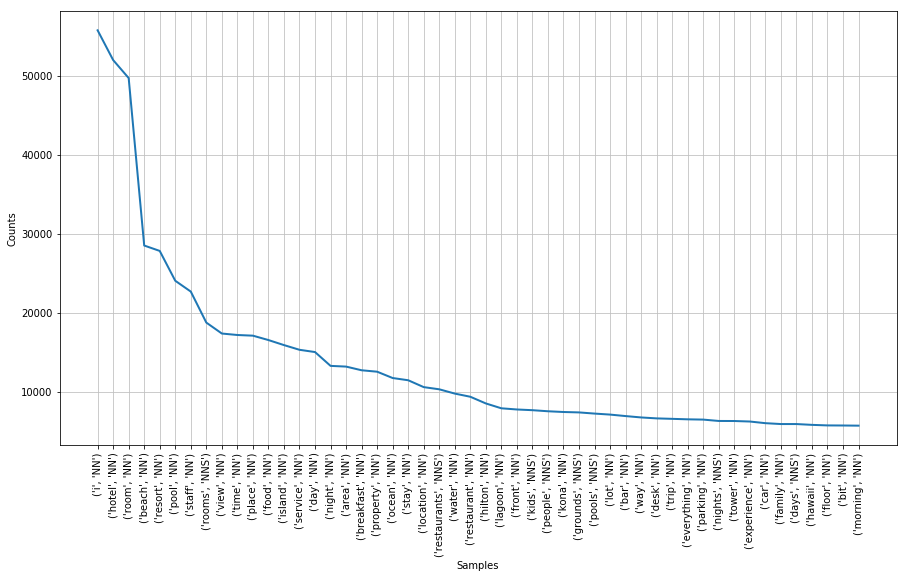

In [38]:
nouns = []
for tag in tags:
    for np in tag:
        if np[1] in ['NN','NNP','NNS','NNPS']: 
            nouns.append(np)

plt.figure(figsize=(15,8))
nltk.FreqDist(nouns).plot(50)

The chart above shows the 50 most commonly occurring nouns in our review corpus. This part requires some subjectivity to determine which nouns are worth exploring more. The first five ("i," "hotel," "room," "beach," "resort") are general and might not be of much help but "pool," "staff, "food," and "service" might warrant further investigation. 

In a real-word setting, we'd probably want to work with managers and industry experts to tease out the best nouns to use. We may also want to consider the time of reference since some reviews may have terse comments regarding something the resort addressed recently (i.e. remodeled pool or improved restaurant menu).

Let's take a deeper look at "pool," "staff," "food," "service," and we'll add in "location" as well since that is one feature that TA also tracks

## VADER Sentiment Analyzer

Understanding the positive and negative emotions consumers have towards a product or service is of significant interest to businesses. While market researchers typically approach these types of problems with survey and focus group methodology, NLP provides some alternative methods that 1) could provide less biased insights and, 2) can cost far less than the price of recruiting survey respondents and focus group participants.

Sentiment Analysis is the NLP approach to uncovering these emotions. While being one of the more challenging NLP tasks, there are a variety of methodologies. We chose to use VADER for this demonstration. You can read more about it [here](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf). Many market researchers readily say that "machines" will never replace humans in understanding other humans, yet VADER itself was actually trained *using humans to score sentiment polarity!*

Some interesting features of the VADER Sentiment Analyzer:

* Considers punctuation as an intensity modifier, so a sentence ending in **"!"** isn't as intense as one ending with **"!!"**
* Considers ALL CAPS as an intensity modifier, so **"great"** isn't as intense as **"GREAT."**
* Considers adjectives and other word modifiers, so **"It's good"** isn't as intense as **"It's really good."**
* Considers conjunctive sentences using "but" as two different sentiments with more weight placed on sentiment after "but."
* Considers tri-grams (i.e. groups of three words together in a sentence) for sentiment "flips" as in **"This resort really isn't all that great."**

In [6]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

def feature_sentiments(feature):
    feature = [sentence + '.' for sentence in text.iloc[:,1] if feature in sentence]
    sentiment = []
    for sentence in feature:
        sentiment.append(sia.polarity_scores(sentence))
    results = sum([item['compound'] for item in sentiment])/len(sentiment)   
    return results

The VADER algorithm takes a sentence as input and compares it to a lexicon created during the initial algorithm training by humans. Each sentence is given positive, neutral, negative, and compound score based on reference to this lexicon and with the 5 bullets above. We will use just the compound score since it is an amalgamation of sentiment scores for each word in a sentence normalized between -1 and 1 with "-1" being "completely negative" and "1" being "completely positive." This is convenient since we can then set our own thresholds for what we believe constitutes positive/neutral/negative.

The above script takes a key word, extracts all sentences from the review corpus that contain it, scores them on sentiment, then averages the compound score across all sentences mentioning the key word(s). We decided to look at the words "pool," "staff," "food," "service," and "location."

In [36]:
features = {'pool': '','staff': '','food': '','service': '','location': ''}
for feature in features.keys():
    features[feature] = feature_sentiments(feature)
    
features

{'food': 0.8752086250000046,
 'location': 0.8731143825719613,
 'pool': 0.8790398362044726,
 'service': 0.8435833755749537,
 'staff': 0.8779128159068393}


So what we can see here is that most mentions of these terms are positive (remember we didn't filter the data by bubble rating so both negative and positive reviews are presented). But let's dig a little deeper: *why* do reviewers rate these positive?

The NLTK also offers a few other tools for NLP that might be helpful. The "concordance" method allows us to choose a key word and see its context within sentences. This can add additional "flavor" to the reason reviewers provided the rating they did.

In [8]:
def concord (text, feature):
    corpus = ' '.join(text.iloc[:,1])
    words = nltk.word_tokenize(corpus.lower())
    concordance = nltk.Text(words)
    return concordance.concordance(feature) 

In [9]:
concord(text,'pool')

Displaying 25 of 24723 matches:
ntastic . we enjoyed our time at the pool . it was a quick stay and would defi
ying to everything on the cheap from pool food service hours to the fairmont b
s that has truly everything ! lovely pool , great waterview from many rooms , 
 can snorkel with , a huge freestyle pool , staff which is super friendly and 
nt you can rent beach / beach-pool / pool cabanas which come with some snacks 
 , grab something in the deli at the pool or get a ride over to the farmlands 
g is beautiful . you may swim in the pool or in the lagoon . there is an equip
 snorkeling , paddle boarding , tide pool exploring and watching the turtles !
softer side and felt a little worn . pool was out of service for half our stay
 rooms havebalconies overlooking the pool and harbor . the japanese gardens ar
ach , a nesting turtles area . great pool , with lots of chaise lounges . fant
 showers ... .one with a tub . large pool with lots of kids running around ...
ounger daughter espe

For example, if we explore the word "pool" we can see more context around reviewers' experience with the resort's pool: 

* **"lovely *pool*, great waterview from many rooms"**
* **"*pool* was out of service for half our stay"**
* **"loved the *pool* and water slide"**

Remember, we are using the full, unfiltered data set so these comments would probably be more helpful if we narrowed our data to a specific resort and/or time span.

## Scattertext Visualizer

As with most pursuits in data exploration, visualization is a helpful tool. NLP is no different. In our exploration of TA reviews we might be interested in what words or phrases best differentiate between positive and negative reviews. For this task we'll look at the bubble ratings reviewers left and define positive reviews as 5 out of 5 bubbles and negative reviews as 1 out of 5 bubbles. We chose this dichotomy since experience in market research shows that people tend to give ratings closer to the middle of a scale unless they feel very strongly one way or the other. 

Scattertext is an open-source library for Python for visualizing how word usage differs between two groups. The process uses a modified version of F-Score calculation (i.e. the harmonic mean of precision and frequency) called "Scaled F-Score" to partition words by groups (you can read more about it and the Scattertext package [here](https://github.com/JasonKessler/scattertext).

In [18]:
neg = data_filter(df, high_bub=1)
pos = data_filter(df, low_bub=5)

scatter_reviews = pd.concat([pos,neg])
scatter_reviews['bubbles'] = scatter_reviews.bubbles.astype(str)

spacy_corpus = spacy.en.English()
scatter_corpus = st.CorpusFromPandas(scatter_reviews, 
                                     category_col='bubbles', 
                                     text_col='review', 
                                     nlp=spacy_corpus).build()

The code above divides our reviews into groups for 1 bubble and 5 bubbles. Each set of reviews is parsed and compared by raw frequency within its category and its frequency across both categories. This effectively scores each word on how representative it is of a 1 or 5 bubble review (again see the Scaled F-Score referenced in the link above).

In the visualization below, each axis represents a review and each point a word. Words in the upper left represent words used more frequently by 5 bubble reviews while bottom right word are more frequently used by 1 bubble reviews. Words that appear in the middle could appear in either so they aren't as differentiating between groups. On the right, we are provided a list of the top words characteristic to each group and characteristic to the entire corpus of text (note: in the given code, words with fewer than 30 mentions are excluded).

A quick review shows that the use of adjectives is really what sets these reviews apart. While not particularly helpful, the words in the "Characteristic" column can give a little more information on what exactly is "superb" or "disgusting." This improves interpretability marginally, but clicking on a word within the visualization will create a list or reviews for each group containing that word. This makes it much easier to do a deeper exploration. Finally, a user can enter their own word to search for in the corpus to see how it is used by each group.  

In [34]:
html = st.produce_scattertext_explorer(scatter_corpus,
                                       category='5',
                                       category_name='5 of 5 bubbles',
                                       not_category_name='1 of 5 bubbles',
                                       minimum_term_frequency = 30,
                                       save_svg_button=True)
open("posneg_scatter.html", 'wb').write(html.encode('utf-8'))
IFrame('posneg_scatter.html', width=1300, height=900)

## Final Remarks

In the body of NLP analytics, there are numerous paths one can take in their analysis. Additional applications could include:

* Being the most popular travel review site online, TA is generating reviews 24/7 from around the world. Creating a data pipeline that regularly collects reviews for processing can be a part of an ongoing customer service effort for a single hotel, a hospitality holding company managing numerous properties, or even a tourism board tasked with keeping visitors' experiences memorable.

* The Scattertext visualization also allows for the hotel name to be attached to each review. While the above code does not include this feature, in a real-world use case it would be imperative to know if a good/bad review was given for your hotel or a competitor's.

* Businesses spend millions annually on market research projects that often provide little value for the cost. Focus groups are a mainstay of the corporate research body of methodologies and attempt to extract similar information. By using online reviews it may be possible to achieve the same level of insight for little to no cost, from thousands of reviewers, and on an ongoing basis.

## Citations

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (ACL): System Demonstrations. 2017.